<a href="https://colab.research.google.com/github/shreenath96/Movie-Recommender-system/blob/main/movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as npy
import pandas as pds
import seaborn as sbn
#!pip install matplotlib --upgrade
import matplotlib as mtlib
import matplotlib.pyplot as mplib
sbn.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#print(mpl.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# load the movie data
movie_dframe = pds.read_csv('movies.csv', low_memory = False, encoding = 'UTF-8') 
movie_dframe = movie_dframe.dropna(axis = 0)

# convert the id to type int and set id as index
movie_dframe = movie_dframe.set_index(movie_dframe['id'].replace(',','').astype(int))
pds.set_option('display.max_colwidth', 20)

# load the movie credits
credits_dframe = pds.read_csv('credits.csv', encoding = 'UTF-8')
credits_dframe = credits_dframe.set_index('id')

# load the movie keywords
keywords_dframe = pds.read_csv('keywords.csv', low_memory=False, encoding='UTF-8') 
keywords_dframe = keywords_dframe.set_index('id')

In [ ]:
# merge everything into a single dataframe 
kc_mrge = keywords_dframe.merge(credits_dframe, left_index=True, right_on='id')
mkc = kc_mrge.merge(movie_dframe[['release_date','genres','overview','title']], left_index=True, right_on='id')
mkc.head

<bound method NDFrame.head of                    keywords                 cast                 crew release_date               genres             overview                title
id                                                                                                                                               
710     [{'id': 701, 'na...  [{'cast_id': 1, ...  [{'credit_id': '...   1995-11-16  [{'id': 12, 'nam...  James Bond must ...            GoldenEye
10634   [{'id': 897, 'na...  [{'cast_id': 1, ...  [{'credit_id': '...   1995-04-26  [{'id': 35, 'nam...  Craig and Smokey...               Friday
755     [{'id': 246, 'na...  [{'cast_id': 1, ...  [{'credit_id': '...   1996-01-19  [{'id': 27, 'nam...  Seth Gecko and h...  From Dusk Till Dawn
5894    [{'id': 919, 'na...  [{'cast_id': 22,...  [{'credit_id': '...   1995-09-15  [{'id': 35, 'nam...  Auggie runs a sm...     Blue in the Face
9070    [{'id': 10988, '...  [{'cast_id': 2, ...  [{'credit_id': '...   1995-06-30  [{'id': 28

In [ ]:
# create an empty DataFrame
nmovies_dframe = pds.DataFrame()

# extract the keywords
nmovies_dframe['keywords'] = mkc['keywords'].apply(lambda x: [i['name'] for i in eval(x)])
nmovies_dframe['keywords'] = nmovies_dframe['keywords'].apply(lambda x: ' '.join([i.replace(" ", "") for i in x]))

# extract the overview
nmovies_dframe['overview'] = mkc['overview'].fillna('')

# extract the release year 
nmovies_dframe['release_date'] = pds.to_datetime(mkc['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != npy.nan else npy.nan)

# extract the actors
nmovies_dframe['cast'] = mkc['cast'].apply(lambda x: [i['name'] for i in eval(x)])
nmovies_dframe['cast'] = nmovies_dframe['cast'].apply(lambda x: ' '.join([i.replace(" ", "") for i in x]))

# extract genres
nmovies_dframe['genres'] = mkc['genres'].apply(lambda x: [i['name'] for i in eval(x)])
nmovies_dframe['genres'] = nmovies_dframe['genres'].apply(lambda x: ' '.join([i.replace(" ", "") for i in x]))

# add the title
nmovies_dframe['title'] = mkc['title']

# merge fields into a tag field
nmovies_dframe['tags'] = nmovies_dframe['keywords'] + nmovies_dframe['cast']+' '+nmovies_dframe['genres']+' '+nmovies_dframe['release_date']

# drop records with empty tags and dublicates
nmovies_dframe.drop(nmovies_dframe[nmovies_dframe['tags'] == ''].index, inplace=True)
nmovies_dframe.drop_duplicates(inplace=True)

In [ ]:
# add a fresh index to the dataframe, which we will later use when refering to items in a vector matrix
nmovies_dframe['movie_id'] = range(0, len(nmovies_dframe))

# Reduce the data to relevant columns
nmovies_dframe = nmovies_dframe[['movie_id', 'title', 'tags']]

# display the data
pds.set_option('display.max_colwidth', 500)
pds.set_option('display.expand_frame_repr', False)

nmovies_dframe.head(5)

,movie_id,title,tags
id,,,
710,0,GoldenEye,cuba falselyaccused secretidentity computervirus secretbase secretintelligenceservice kgb satellite specialcar cossack electromagneticpulse timebomb st.petersburgrussia ejectionseat redarmyPierceBrosnan SeanBean IzabellaScorupco FamkeJanssen JoeDonBaker JudiDench GottfriedJohn RobbieColtrane AlanCumming TchékyKaryo DesmondLlewelyn SamanthaBond MichaelKitchen SerenaGordon SimonKunz BillyJ.Mitchell ConstantineGregory MinnieDriver MichelleArthur RavilIsyanov Adventure Action Thriller 1995
10634,1,Friday,rapmusic parentchildrelationship rapper jobIceCube ChrisTucker NiaLong TomListerJr. JohnWitherspoon AnnaMariaHorsford ReginaKing PaulaJaiParker FaizonLove DJPooh TonyCox AnthonyJohnson BernieMac MeaganGood TerriJ.Vaughn F.GaryGray ReynaldoRey MichaelClarkeDuncan Comedy 1995
755,2,From Dusk Till Dawn,dancing brotherbrotherrelationship sexualobsession showdown sheriff eroticism nudity bankrobber vampire holywater siege stripper priest explosion extremeviolence bankrobbery preacher hostagesituation crucifix recreationalvehicle bloodspurting conveniencestore femalevampire mexicanamericanborder nightclubentertainer boaconstrictorGeorgeClooney QuentinTarantino HarveyKeitel JulietteLewis ErnestLiu SalmaHayek CheechMarin DannyTrejo TomSavini FredWilliamson MichaelParks BrendaHillhouse JohnSaxon...
5894,3,Blue in the Face,smoking cornershop cigarette tobacco cigar independentfilmHarveyKeitel LouReed MichaelJ.Fox RoseanneBarr LilyTomlin GiancarloEsposito JoséZúñiga Madonna MiraSorvino KeithDavid VictorArgo JimJarmusch JaredHarris MelGorham MalikYoba JohnLurie StephenGevedon SharifRashed PeggyGormley RuPaul Comedy 1995
9070,4,Mighty Morphin Power Rangers: The Movie,basedontvseries tokusatsu superheroteam ethnicdiversity supersentai powerrangers mightymorphinpowerrangers mmprAmyJoJohnson JasonDavidFrank DavidYost JohnnyYongBosch SteveCardenas KaranAshley PaulSchrier JasonNarvy PaulFreeman GabrielleFitzpatrick JamieCroft PeterMochrie Action Adventure ScienceFiction Family Fantasy 1995


In [ ]:
# set a custom stop list from nltk
s_words = list(stopwords.words('english'))

# create the tfid vectorizer, alternatively you can also use countVectorizer
tfidf_vector = TfidfVectorizer(max_features = 5000, analyzer = 'word', stop_words = set(s_words))
vector_data = tfidf_vector.fit_transform(nmovies_dframe['tags'])
count_matrix = pds.DataFrame(vector_data.toarray(), index = nmovies_dframe['tags'].index.tolist())

print(count_matrix)

        0     1     2     3     4     5     6     7     8     9     ...  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999
710      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
10634    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
755      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
5894     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
9070     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
294682   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.

In [ ]:
# reduce dimensionality for improved performance
trunc_svd = TruncatedSVD(n_components = 3000)
new_rdata = trunc_svd.fit_transform(count_matrix)

# compute the cosine similarity matrixS
cos_similarity = cosine_similarity(new_rdata)


print(tfidf_vector.get_feature_names_out()[1500:1550])

['hayleyatwell' 'heart' 'heavymetal' 'hecker' 'heidimoneymaker'
 'heikemakatsch' 'heirtothethrone' 'heist' 'heldcaptive' 'helena'
 'helenabonhamcarter' 'helenmccrory' 'helenmirren' 'helicopter'
 'henrygoodman' 'henrylloyd' 'henson' 'hermes' 'hermionecorfield' 'hero'
 'heroin' 'highschool' 'hill' 'himalaya' 'hiroshikasuga' 'hiroyukisanada'
 'hiroyukitagawa' 'history' 'hitman' 'ho' 'hobbit' 'holiday' 'hollydorff'
 'hollyhunter' 'holygrail' 'holywater' 'homeinvasion' 'honeymoon' 'hong'
 'hongkong' 'hooligan' 'hope' 'hopedavis' 'horror' 'horrorspoof' 'horse'
 'horserace' 'hospital' 'hostage' 'hostility']


In [ ]:
# create a function that takes in movie title as input and returns a list of the most similar movies
def recommender(title, n, cos_sim = cos_similarity):
    # print(df_movies[df_movies.title==title].new_id)
    # for i in df_movies.title:
    #   if i == title:
    #     print(i)
    # get the index of the movie that matches the title
    m_idx = nmovies_dframe[nmovies_dframe.title == title]
    try:
      m_idx= m_idx.movie_id.values[0]
    # Logs the error appropriately. 
    except IndexError:
      print("Movie not in Database..Please try another movie!")
    
    #print(movie_index, title)
    
 
    # get the pairwsie similarity scores of all movies with that movie and sort the movies based on the similarity scores
    sim_score = sorted(list(enumerate(cos_sim[m_idx])), key = lambda x: x[1], reverse = True)
    
    # checks if recommendations are limited
    if n > 0:
      sim_score = sim_score[1:n+1]
        
    # get the movie indices of the top similar movies
    mv_indx = [i[0] for i in sim_score]
    sscore = [i[1] for i in sim_score]
    
    # return the top n most similar movies from the movies df
    top_titles = top_titles = pds.DataFrame(nmovies_dframe.iloc[mv_indx]['title'])
    top_titles['sim_scores'] = sscore
    top_titles['ranking'] = range(1, len(top_titles) + 1)

    return top_titles, sim_score

In [ ]:
# visualize the results
def display_results(mv_name, top_titles):
    try:
      fix, ax = mplib.subplots(figsize = (11, 5))
      sbn.barplot(data = top_titles, y = 'title', x = 'sim_scores', color = 'cyan')
      mplib.xlim((0,1))
      mplib.title(f'Top 15 recommendations for {mv_name}')
      val_list = ['{:.2}'.format(elm) for elm in list(top_titles['sim_scores'])]
    
      ax.bar_label(container = ax.containers[0], labels = val_list, size = 12)
    except Exception as e:
      print("Movie not in database!!")

Movie not in database!!


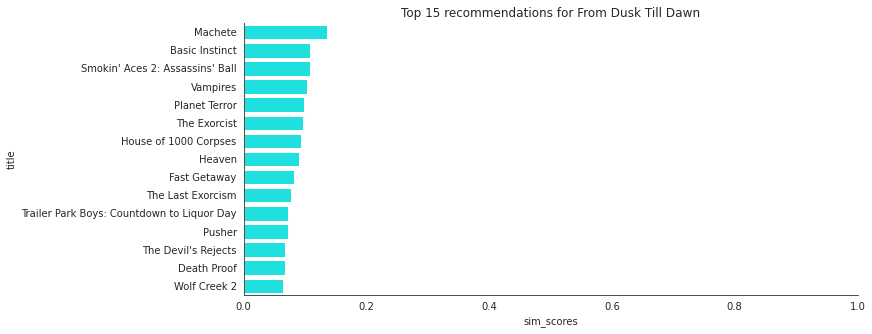

In [ ]:
mv_name = 'From Dusk Till Dawn'
n_recommendations = 15
top_titles, _ = recommender(mv_name, n_recommendations)
display_results(mv_name, top_titles)

Movie not in database!!


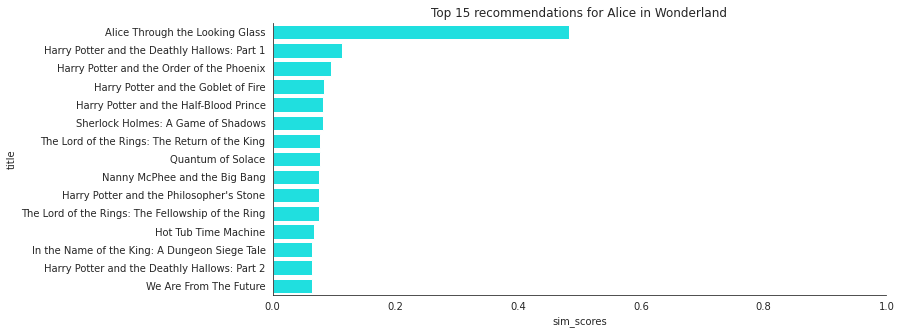

In [ ]:
mv_name = 'Alice in Wonderland'
n_recommendations = 15
top_titles, _ = recommender(mv_name, n_recommendations)
display_results(mv_name, top_titles)

Movie not in database!!


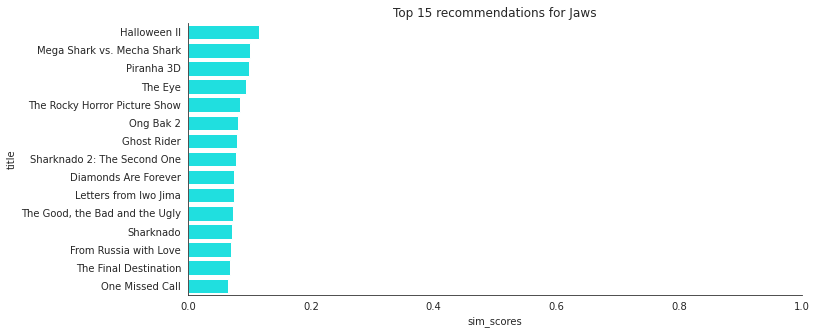

In [ ]:
mv_name = 'Jaws'
n_recommendations = 15
top_titles, _ = recommender(mv_name, n_recommendations)
display_results(mv_name, top_titles)

Movie not in Database..Please try another movie!
Movie not in database!!


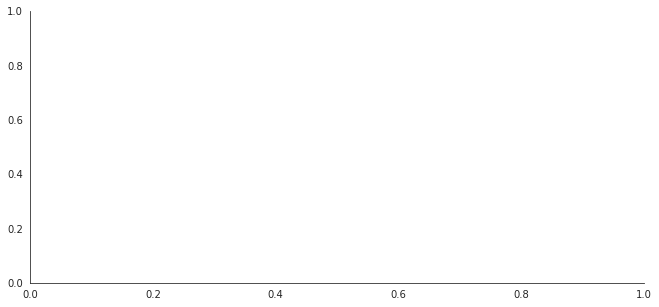

In [ ]:
mv_name = 'Sceptre'
n_recommendations = 15
top_titles, _ = recommender(mv_name, n_recommendations)
display_results(mv_name, top_titles)

AttributeError: ignored

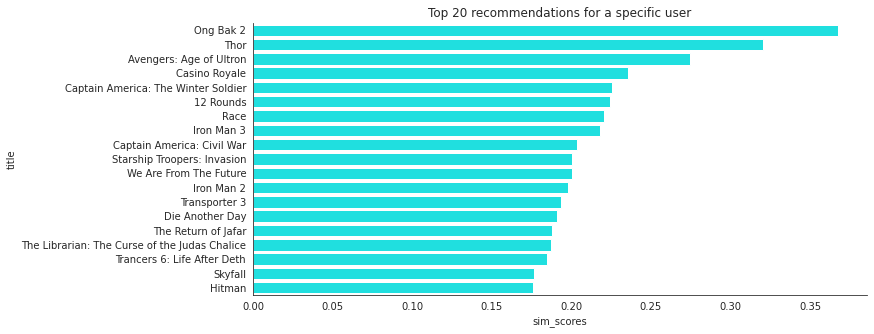

In [ ]:
# list of movies a user has seen
movie_list = ['The Lion King','Blade Runner', 'Quantum of Solace', 'The Avengers', 'Skyfall']

# create a copy of the movie dataframe and add a column in which we aggregated the scores
u_scores = pds.DataFrame(nmovies_dframe['title'])
u_scores['sim_scores'] = 0.0

# top number of scores to be considered for each movie
n_recommendations = 10000
for mv_name in movie_list:
    top_titles, _ = recommender(mv_name, n_recommendations)
    # aggregate the scores
    u_scores = pds.concat([u_scores, top_titles[['title', 'sim_scores']]]).groupby(['title'], as_index = False).sum({'sim_scores'})
# sort and print the aggregated scores
user_top_titles = u_scores.sort_values(by = 'sim_scores', ascending = False)[1:20]

# visualize the results
fix, ax = mplib.subplots(figsize=(11, 5))
sbn.barplot(data = user_top_titles, y = 'title', x = 'sim_scores', color = 'cyan')
mplib.title(f'Top 20 recommendations for a specific user')
val_list = ['{:.2}'.format(elm) for elm in list(user_top_titles['sim_scores'])]
ax.bar_label(container = ax.containers[0], labels = val_list, size = 12)